In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from tpot import TPOTClassifier
from tpot import TPOTRegressor

# Lesson 08 Homework - Hyperparameter Optimization (Project)

**Note: This introduction is not included in the Canvas quiz.**

For this project you're going to apply hyperparameter optimization to both a regression and a classification problem. It looks like a lot to do below, but it's mostly a matter of modifying code from the presentation. 

## Objective

For each of the models in parts 1 and 2 below, apply the following 4 tuning methods from the presentation: GridSearchCV, RandomSearchCV, BayesSearchCV, and TPOT.
* **For TPOT**: In Part 1 you will only do hyperparameter optimization for ExtraTreesRegressor. In Part 2 you will do **both** hyperparameter optimization and also run TPOT and let it choose the model. See the presentation for examples of both.

## Specific Quiz Questions

Follow along and use the required parameters and random seeds so that you can correctly answer the quiz questions.

### Regarding data

* To answer the multiple choice quiz questions, you'll need to use the data we have chosen. 
* We encourage you to try these out on your own data, too, to deepen your learning.
 

# **Part 1** - Optimize Extra Trees Regressor

### Find optimized hyperparameters for an extra trees regression model. 

In the lesson, our TPOT AutoML code suggested that a viable algorithm to explore would be the `ExtraTreesRegressor`. For part 1 of your homework, you'll use sklearn's ExtraTreesRegressor and attempt to optimize the hyperparameters.

You must use the diamonds data used in the presentation.  **You do not need to include the TPOT general search for this problem** (use TPOT to optimize ExtraTreesRegressor, but don't run TPOT to choose a model). Here are ranges for a subset of the hyperparameters:

Hyperparameter |Type | Default Value | Typical Range
---- | ---- | ---- | ----
n_estimators | discrete / integer | 100 | 10 to 150
min_samples_split | discrete / integer | 2 | 2 to 20
min_samples_leaf | discrete / integer | 1 | 1 to 10
max_features | discrete/integer | auto | 1 to 30
bootstrap | discrete / boolean | False | True, False (use this order where possible)


Note: there other hyperparameters that could be added, but we will focus on these for the project. Consult the 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html">documentation for sklearn ExtraTreesRegressor</a> to see all of the available hyperparameters.


## **Question 1: Setup** <font color="magenta">(1 points)</font>

* Load the diamonds dataset (diamonds_transformed.csv in the data directory). 
* Set up your X and y variables. 
* Split into 80% training data and 20% testing data. 
* **Use random_state = 123**

How many rows are in your training data?



In [2]:
dmd = pd.read_csv('data/diamonds_transformed.csv')
X, y = dmd[dmd.columns.drop('Price')], dmd['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## **Question 2** <font color="magenta">(1 points)</font>
In the following cell, we provide you with the same `my_regression_results` function we used in the lesson. Create an `ExtraTreesRegressor` model using **random_state=123**. Fit your model. Use the `my_regression_results` function to get the Root Mean Squared Error on the test data.

What is the RMSE (Root Mean Squared Error) using the default hyperparameters?

* 1875.57
* 2056.87
* 9688.00
* 1833.88
* **2053.20**


In [3]:
#function to easily assess different models (not included in Canvas Quiz)
def my_regression_results(model):
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))

    y_pred = model.predict(X_test)
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))
    return (round(rmse, 2))

Model r-squared score from test data: 0.9609
Mean squared error on test data: 4215635.99
Root mean squared error on test data: 2053.20


2053.2

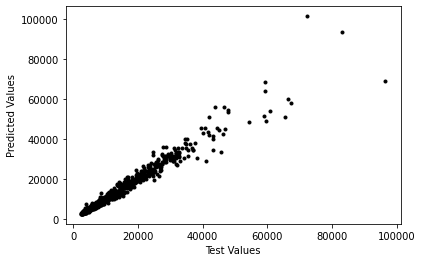

In [4]:
ex_trees = ExtraTreesRegressor(random_state=123)
ex_trees.fit(X_train, y_train)
my_regression_results(ex_trees)

## **Question 3** (Manually Graded) <font color="magenta">(2 points)</font>

Modify the `track_results` function to work with the Extra Trees Regressor hyperparameters. Enter your results based on the default hyperparameters and display the dataframe of results.

In the Canvas quiz, copy your code and provide a screenshot of the output.


In [5]:
def track_results(approachName, params, rmse, fits, current, show=True):
    current['Approach'].append(approachName)
    current['RMSE'].append(rmse)
    current['Fits'].append(fits)
    for k in params.keys():
        current[k].append(params[k])
    if show:
        df = pd.DataFrame(current)
        df = df.sort_values('RMSE', ascending=True)
        display(df)
    return(current)

par = ex_trees.get_params()
par_to_keep =  ['bootstrap', 'max_features','min_samples_leaf', 'min_samples_split', 'n_estimators']

setup = {'Approach': [],
         'bootstrap': [],
         'max_features': [],
         'min_samples_leaf': [],
         'min_samples_split': [],
         'n_estimators': [],
         'Fits': [],
         'RMSE': []
        }

defaults = {k:par[k] for k in par_to_keep}

current = track_results('Default ExtraTreesRegressor', defaults, 2053.20, 1, setup)

,Approach,bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators,Fits,RMSE
0,Default ExtraTreesRegressor,False,auto,1,2,100,1,2053.2


## ExtraTreesRegressor Grid Search 

Perform a cross-validated grid search using the following values for your hyperparameter search space.

* n_estimators: [50, 100, 150]
* max_features: [1, 15, 30]
* min_samples_split: [2, 8]
* min_samples_leaf: [1, 15]
* bootstrap: [True, False]

Use the following setting in your grid search:
* cv=5

*Note: this took about 16 minutes to run on CoCalc*

Be sure to track your results using your `track_results` function.

### **Question 4:** <font color="magenta">(2 points)</font>
**What is the RMSE of your optimized grid search, rounded to 2 digits?**




### **Question 5:** <font color="magenta">(2 points)</font>
**What is the optimal value of max_features chosen by the grid search?**

* 1
* **15**
* 30


In [6]:
#use this seed
np.random.seed(123)

params = {
        'n_estimators': [50, 100, 150],
        'max_features': [1, 15, 30],
        'min_samples_split': [2, 8],
        'min_samples_leaf': [1, 15],
        'bootstrap': [True, False]
        }

grid_search = GridSearchCV(ex_trees,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=123), n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'max_features': [1, 15, 30],
                         'min_samples_leaf': [1, 15],
                         'min_samples_split': [2, 8],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, verbose=1)

{'bootstrap': False, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Model r-squared score from test data: 0.9634
Mean squared error on test data: 3945481.66
Root mean squared error on test data: 1986.32


1986.32

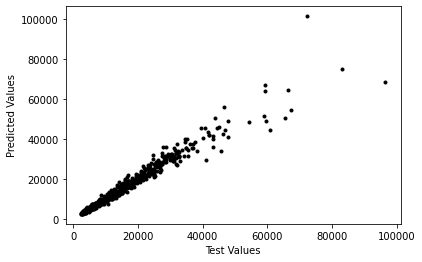

In [7]:
print(grid_search.best_params_)
my_regression_results(grid_search)

In [8]:
current = track_results('GridSearch ExtraTreesRegressor', grid_search.best_params_, 1986.32, 360, current)

,Approach,bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators,Fits,RMSE
1,GridSearch ExtraTreesRegressor,False,15,1,2,150,360,1986.32
0,Default ExtraTreesRegressor,False,auto,1,2,100,1,2053.20


## Randomized Search

Use the following values to set up your randomized search space:
* n_estimators: random integers between 10 and 150
* min_samples_split: random integers between 2 and 20
* min_samples_leaf: random integers between 1 and 20
* max_features:  random integers between 1 and 30
* bootstrap: True or False (in that order)

Use the following settings for your randomized search:

* n_iter of 25
* cv of 5
* random_state of 123


### **Question 6** <font color="magenta">(2 points)</font>
**What is the RMSE of your randomized search, rounded to 2 digits?**





### **Question 7** <font color="magenta">(2 points)</font>
**What is the max_features chosen by your random search?**

* 5
* 7
* 9
* 11
* 13

In [9]:
params = {
        'n_estimators': randint(10, 150),
        'max_features': randint(1, 30),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'bootstrap': [True, False]
        }

random_search = RandomizedSearchCV(
    ex_trees,
    param_distributions=params,
    random_state=123,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=123),
                   n_iter=25, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96b8b27bd0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96eba36450>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96eba36210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96eba36190>},
                   random_state=123, return_train_score=True, verbose=1)

Model r-squared score from test data: 0.9634
Mean squared error on test data: 3945481.66
Root mean squared error on test data: 1986.32


1986.32

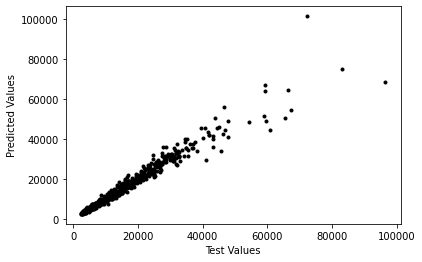

In [10]:
my_regression_results(grid_search)

In [11]:
current = track_results('RandomSearch ExtraTreesRegressor', random_search.best_params_, 1986.32, 125, current)

,Approach,bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators,Fits,RMSE
1,GridSearch ExtraTreesRegressor,False,15,1,2,150,360,1986.32
2,RandomSearch ExtraTreesRegressor,False,11,2,2,123,125,1986.32
0,Default ExtraTreesRegressor,False,auto,1,2,100,1,2053.20


#### Bayesian Optimization

For your Bayesian Optimization, we'll use the same ranges we used in random search. You won't need to wrap any of your integer ranges in Integer(), but you will need to use `Categorical([True, False])` for your bootstrap parameter.

Use the following values to set up your search space:
* n_estimators: integers between 10 and 150
* min_samples_split: integers between 2 and 20
* min_samples_leaf: integers between 1 and 10
* max_features:  integers between 1 and 30
* bootstrap: Categorical of True, False (in that order)

Use the following settings for your search:

* n_iter of 25
* cv of 5
* random_state of 123

### **Question 8** <font color="magenta">(2 points)</font>
**What is the RMSE of your Bayesian search, rounded to 2 digits?**




### **Question 9** <font color="magenta">(2 points)</font>
**What is the value of min_samples_leaf chosen by your Bayesian search?**

* 1
* 3
* 5
* 7
* 9




In [12]:
params = {
        'n_estimators': (10, 150),
        'max_features': (1, 30),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
        'bootstrap': Categorical([True, False])
        }

bayes_search = BayesSearchCV(
    ex_trees,
    search_spaces=params,
    random_state=123,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=123), n_iter=25,
              random_state=123, return_train_score=True,
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'max_features': (1, 30),
                             'min_samples_leaf': (1, 20),
                             'min_samples_split': (2, 20),
                             'n_estimators': (10, 150)},
              verbose=1)

125
Model r-squared score from test data: 0.9642
Mean squared error on test data: 3860641.95
Root mean squared error on test data: 1964.85


1964.85

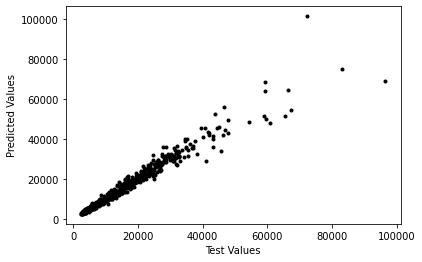

In [13]:
print(bayes_search.total_iterations)
my_regression_results(bayes_search)

In [14]:
current = track_results('BayesSearch ExtraTreesRegressor', bayes_search.best_params_, 1964.85, 125, current)

,Approach,bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators,Fits,RMSE
3,BayesSearch ExtraTreesRegressor,False,18,1,2,133,125,1964.85
1,GridSearch ExtraTreesRegressor,False,15,1,2,150,360,1986.32
2,RandomSearch ExtraTreesRegressor,False,11,2,2,123,125,1986.32
0,Default ExtraTreesRegressor,False,auto,1,2,100,1,2053.20


#### TPOT

For TPOT, you'll use the following search config values:

* n_estimators: each of the following integers - 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150
* min_samples_split: all integers between 2 and 20 (inclusive of 20)
* 'min_samples_leaf': all integers between 1 and 20 (inclusive of 20)
* 'max_features': all integers between 1 and 30 (inclusive of 30)
* 'bootstrap': either zero or 1 ([0,1] in that order)

Use 5 generations and a population size of 10 and a cv of 3. Use random state of 123. (Note, this is not nearly enough generations or big enough population to truly find the best hyperparameters. But, we also don't want you to have to sit and watch it chug through for an hour.)  We'll include stacked models here, so do not use `template='Regressor'` in your configuration dictionary.

**Hint** the ExtraTreesRegressor is from the sklearn.ensemble package.


### **Question 10** <font color="magenta">(2 points)</font>
**What is the RMSE of your TPOT search, rounded to 2 digits?**




### **Question 11** <font color="magenta">(2 points)</font>
**What is the value of n_estimators chosen by your TPOT search?**. More than one value may be possible since models can be nested or stacked.  Check all possible values for n_estimator that occur in your TPOT pipeline.  Report the results of the "inner" model in your tracking results data frame.

* 60
* 70
* 80
* **90**
* 110



In [15]:
tpot_config = {
    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': np.arange(10, 151, 10),
        'max_features': range(1, 31),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [0, 1]
    }
}

tpot = TPOTRegressor(scoring = 'r2',
                     generations=5,
                     population_size=10,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=3,
                     random_state=123)

tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.9532305765586867

Generation 2 - Current best internal CV score: 0.9629588119514606

Generation 3 - Current best internal CV score: 0.9629588119514606

Generation 4 - Current best internal CV score: 0.9629588119514606

Generation 5 - Current best internal CV score: 0.9652311185911997

Best pipeline: ExtraTreesRegressor(ExtraTreesRegressor(input_matrix, bootstrap=1, max_features=18, min_samples_leaf=11, min_samples_split=12, n_estimators=90), bootstrap=0, max_features=28, min_samples_leaf=2, min_samples_split=18, n_estimators=110)


TPOTRegressor(config_dict={'sklearn.ensemble.ExtraTreesRegressor': {'bootstrap': [0,
                                                                                  1],
                                                                    'max_features': range(1, 31),
                                                                    'min_samples_leaf': range(1, 21),
                                                                    'min_samples_split': range(2, 21),
                                                                    'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150])}},
              cv=3, generations=5, population_size=10, random_state=123,
              scoring='r2', verbosity=2)

## Question 12 (Manually Graded) <font color="magenta">(2 points)</font>

Take a screenshot of your final results dataframe from the `track_results` function and upload it. Briefly comment on the results.

Model r-squared score from test data: 0.9681
Mean squared error on test data: 3443303.67
Root mean squared error on test data: 1855.61


/Users/bryce/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/bryce/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"


1855.61

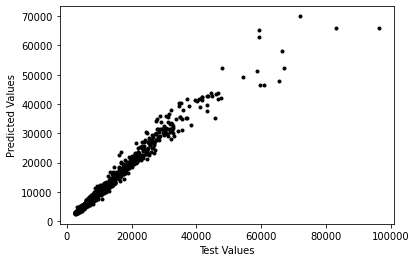

In [16]:
my_regression_results(tpot)

In [17]:
tpot_best_params = {'bootstrap':True, 'max_features':18, 'min_samples_leaf':11, 'min_samples_split':12, 'n_estimators':90}
current = track_results('TPOT ExtraTreesRegressor', tpot_best_params, 1855.61, 180, current)

,Approach,bootstrap,max_features,min_samples_leaf,min_samples_split,n_estimators,Fits,RMSE
4,TPOT ExtraTreesRegressor,True,18,11,12,90,180,1855.61
3,BayesSearch ExtraTreesRegressor,False,18,1,2,133,125,1964.85
1,GridSearch ExtraTreesRegressor,False,15,1,2,150,360,1986.32
2,RandomSearch ExtraTreesRegressor,False,11,2,2,123,125,1986.32
0,Default ExtraTreesRegressor,False,auto,1,2,100,1,2053.20


<font color="green">Don't forget to comment on your results. Comments should include some information about which method you'd choose and why. Keep in mind that the best method to use depends on how long it take to fit the model.  For a very expensive model (e.g. a large neural network) we might choose Bayesian Optimization, but for a cheap model we can probably afford to do an exhaustive grid search.</font>

In this case, and in light of the final results, I would go with the obvious choice of using the TPOT model. This is based on two lines of reasoning. The first is that considering the overhead for grid search, and the length of time necessary to find meaningful results with random search (and discounting the default as well), the choice really boils down to Bayes search and genetic algorithms. The second consideration is more along the lines of Occam's razor, and between Bayes and genetic optimization, TPOT won out by finding the most simple model. It has less "trees" in the random forest, and is therefore the best choice for a parsimonious, easier to understand model.

# **Part Two** - Loan Classification

In part two, we'll explore optimizing hyperparameters for loan classification.

### Notes:

#### About the data
The first cell below loads a subset of the loans default data from DS705 and your job is to predict whether a loan defaults or not.  The `status_bad` column is the target column and a 1 indicates a loan that defaulted.  We have selected a subset of the original data that includes 2000 each of good and bad loans.  The data has already been cleaned and encoded.

#### This is classification, not regression
The score for each model will be accuracy and not RMSE.  Your summary table should include accuracy, sensitivity, and precision for each optimized model applied to the test data.  (<a href="https://classeval.wordpress.com/introduction/basic-evaluation-measures/">Here is a nice overview of metrics for binary classification data</a>) that includes definitions of accuracy and such.

### Load the Data
In the following cell, we load the data for you and split it into train and test dataframes. Do not change anything in this cell. (Cell not included in Canvas Quiz.)

In [18]:
# Do not change this cell for loading and preparing the data
import pandas as pd
import numpy as np

X = pd.read_csv('./data/loans_subset.csv')

# split into predictors and target
# convert to numpy arrays for xgboost, OK for other models too
y = np.array(X['status_Bad']) # 1 for bad loan, 0 for good loan
X = np.array(X.drop(columns = ['status_Bad']))

# split into test and training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## **Question 13** - Display Results Function (Manually graded)<font color="magenta">(2 points)</font>

In the next cell, we've demonstrated using the LogisticRegression model to perform classification and generate a confusion matrix.

**Hint:** You can read more about the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html">confusion_matrix function</a> and a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">classification report function</a> in the Scikit-learn documentation. Both are also demonstrated in the extras folder of this lesson.

In [19]:
# we do need to go higher than the default iterations for the solver to get convergence
# and the explicity declaration of the solver avoids a warning message, otherwise
# the parameters are defaults.
logreg_model = LogisticRegression(solver='lbfgs',max_iter=1000)

#fit the model
logreg_model.fit(X_train, y_train)

# Use score method to get accuracy of model
score = logreg_model.score(X_test, y_test) # this is accuracy
print(f'The accuracy is {score}')

# obtaining the confusion matrix and making it look nice
y_pred = logreg_model.predict(X_test)

# must put true before predictions in confusion matrix function
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[1,0]), 
    index=['true:bad', 'true:good'], 
    columns=['pred:bad','pred:good']
)
display(cmtx)

The accuracy is 0.565


,pred:bad,pred:good
true:bad,110,87
true:good,87,116


Based on the example above write a function called `my_classifier_results` modeled after `my_regression_results` that applies a model to the test data and prints out the accuracy, sensitivity, precision, and the confusion matrix and returns the accuracy, sensitivity and precision.  There is no need to make a plot.

Call your function using the logistic regression model we just demonstrated. (Note that your confusion matrix and accuracy should match what is shown above.) Upload the code and a screenshot of the output.




In [20]:
# Solution for 13
def my_classifier_results(model):
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report['accuracy']
    sens = report['0']['recall']
    prec = report['0']['precision']
    print(f'Accuracy: {acc}\nSensitivity: {sens:0.3f}\nPrecision: {prec:0.3f}')
    
    cmtx = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[1,0]), 
        index=['true:bad', 'true:good'], 
        columns=['pred:bad','pred:good']
        )
    display(cmtx)
    return(acc, sens, prec)

acc, sens, prec = my_classifier_results(logreg_model)

Accuracy: 0.565
Sensitivity: 0.571
Precision: 0.571


,pred:bad,pred:good
true:bad,110,87
true:good,87,116


### XGBoost Classifier
The algorithm that we will use to tune hyperparameters is the XGBClassifier algorithm from XGBoost. We've included the hyperparameters we'll tune and their defaults below:

Hyperparameter | Type | Default Value | Typical Range
---- | ---- | ---- | ----
n_estimators | discrete / integer | 100 | 50 to 150
max_depth | discrete / integer | 3| 1 to 10
min_child_weight | discrete / integer | 1 | 1 to 20
learning_rate | continuous / float | 0.1 | 0.001 to 1
subsample | continuous / float | 1 | 0.05 to 1
reg_lambda | continuous / float | 1 | 0 to 5
reg_alpha  | continuous / float | 0 | 0 to 5

### **Question 14** - <font color="magenta">(2 points)</font>
Generate the Default XBGClassifer Model. Note, you'll need to pass in objective = 'binary:logistic' when you instantiate the XGBClassifier.

What is the accuracy of the default model, rounded to 3 digits?





In [21]:
xgb_class = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error', use_label_encoder=False)
xgb_class.fit(X_train, y_train)
acc, sens, prec = my_classifier_results(xgb_class)

Accuracy: 0.635
Sensitivity: 0.655
Precision: 0.636


,pred:bad,pred:good
true:bad,121,76
true:good,70,133


## Tracking Results Function

Create a `track_results_classifier` function based on the `track_results` function. You'll be tracking each of the XGBClassifier hyperparameters as well as the name of the optimization approach, accuracy, precision, recall, and number of fits.

Add the results from your default XGBClassifier model to the tracker.

(Note: this is not graded here, but the output will be graded as part of the summary.)

In [22]:
#a function to track the results of our different hyperparameter optimization approaches
def track_results_classifier(approachName, params, accuracy, recall, precision, fits, current, show=True):
    current['Approach'].append(approachName)
    current['Accuracy'].append(accuracy)
    current['Sensitivity'].append(round(recall, 3))
    current['Precision'].append(round(precision, 3))
    current['Fits'].append(fits)
    for k in params.keys():
        current[k].append(params[k])
    if show:
        df = pd.DataFrame(current)
        df = df.sort_values('Accuracy', ascending=False)
        display(df)
    return(current)

setup = {'Approach': [],
         'learning_rate': [],
         'max_depth': [],
         'min_child_weight': [],
         'n_estimators': [],
         'reg_alpha': [],
         'reg_lambda': [],
         'subsample': [],
         'Fits': [],
         'Accuracy': [],
         'Precision': [],
         'Sensitivity': []
        } 

defaults = {
    'learning_rate': 0.300000012,
         'max_depth': 6,
         'min_child_weight': 1,
         'n_estimators': 100,
         'reg_alpha': 0,
         'reg_lambda': 1,
         'subsample': 1,
}

current = track_results_classifier('Default XGBClassifier', defaults, acc, sens, prec, 1, setup, True)

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
0,Default XGBClassifier,0.3,6,1,100,0,1,1,1,0.635,0.636,0.655


## Grid Search for XGBClassifier
Perform a grid search using the following parameters:

* learning_rate: [0.01, 0.1],
* max_depth: [3, 6],
* n_estimators: [10, 100],
* subsample: [0.5, 1],
* min_child_weight: [1, 20],
* reg_lambda: [1, 3],
* reg_alpha: [0, 1]

Use the following setting in your GridSearch:

* cv = 3

Set the np.random.seed to 123 (done for you in the cell below).

*Note: This is a smaller than optimal grid, but we don't want you to have to wait forever to process. On CoCalc, this took about 10 minutes to run.

## **Question 15** <font color="magenta">(2 points)</font>

What is the **accuracy** for your Grid Search, rounded to 3 digits?



## **Question 16** <font color="magenta">(2 points)</font>

How many **fits** did your Grid Search do?

* 384
* 398
* 279
* 400
* 375


In [23]:
#Keep this random seed
np.random.seed(123)

params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 6],
    "n_estimators": [10,100],
    "subsample": [0.5, 1],
    "min_child_weight": [1, 20],
    "reg_lambda": [1, 3],
    "reg_alpha": [0, 1]
}

# setup the grid search
grid_search = GridSearchCV(xgb_class,
                           param_grid=params,
                           cv=3,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     u

In [24]:
acc, sens, prec = my_classifier_results(grid_search)
current = track_results_classifier('GridSearch XGBClassifier', grid_search.best_params_, acc, sens, prec, 384, current, True)

Accuracy: 0.675
Sensitivity: 0.655
Precision: 0.689


,pred:bad,pred:good
true:bad,137,60
true:good,70,133


,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
1,GridSearch XGBClassifier,0.1,6,20,10,1,1,0.5,384,0.675,0.689,0.655
0,Default XGBClassifier,0.3,6,1,100,0,1,1.0,1,0.635,0.636,0.655


### Random Search
Use the following parameters to generate a random search:

* learning_rate: any value from the list [0.001, 0.01, 0.1, 0.5, 1.]
* max_depth: any random integer between 1 and 10
* n_estimators: any random integer between 50 and 150
* subsample: uniform(0.05, 0.95)
* min_child_weight: any random integer between 1 and 20
* reg_alpha: uniform(0, 5)
* reg_lambda: uniform(0, 5)

Use the following settings in your random search:

* random_state = 123
* n_iter = 25
* cv = 3

## **Question 17** <font color="magenta">(2 points)</font>

What is the **accuracy** for your Random Search, rounded to 3 digits?



## **Question 18** <font color="magenta">(2 points)</font>

What is the **learning_rate** chosen by your Random Search?

* .001
* .01
* .1
* .5
* .1


In [25]:
params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1],
    "max_depth": randint(1,10),
    "n_estimators": randint(50,150),
    "subsample": uniform(0.05, 0.95),
    "min_child_weight": randint(1, 20),
    "reg_lambda": uniform(0, 5),
    "reg_alpha": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    xgb_class,
    param_distributions=params,
    random_state=123,
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False,
                                           eval_metric='error', gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constr...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96f93c1690>,
         

In [26]:
acc, sens, prec = my_classifier_results(random_search)
current = track_results_classifier('RandomSearch XGBClassifier', random_search.best_params_, acc, sens, prec, 75, current, True)

Accuracy: 0.65
Sensitivity: 0.650
Precision: 0.657


,pred:bad,pred:good
true:bad,128,69
true:good,71,132


,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
1,GridSearch XGBClassifier,0.1,6,20,10,1.000000,1.000000,0.500000,384,0.675,0.689,0.655
2,RandomSearch XGBClassifier,0.5,1,7,64,2.486544,3.416315,0.920864,75,0.650,0.657,0.650
0,Default XGBClassifier,0.3,6,1,100,0.000000,1.000000,1.000000,1,0.635,0.636,0.655


### Bayesian Optimization

For your Bayesian Optimization, use the following parameters:
* learning_rate: Any of the following values - [0.001, 0.01, 0.1, 0.5, 1.]) (Hint: you'll need to use categorical for this one)
* max_depth: Any integer between 1 and 10
* n_estimators: Any integer between 10 and 150
* subsample: Any float between 0.05 and .95
* min_child_weight: Any integer between 1 and 20
* reg_alpha: Any integer between 0 and 5
* reg_lambda: Any integer between 0 and 5

For your call to BayesSearchCV use the following:
* random_state = 123
* n_inter = 15
* cv = 3

## **Question 19** <font color="magenta">(2 points)</font>

What is the **accuracy** for your Bayes Search, rounded to 3 decimal places?



## **Question 20** <font color="magenta">(2 points)</font>

What is the **precision** for your Bayes Search, rounded to 3 decimal places?


In [27]:
params = {
    "learning_rate": Categorical([0.001, 0.01, 0.1, 0.5, 1]),
    "max_depth": (1,10),
    "n_estimators": (10,150),
    "subsample": Real(0.05, 0.95),
    "min_child_weight": (1, 20),
    "reg_lambda": (0, 5),
    "reg_alpha": (0, 5)
}

bayes_search = BayesSearchCV(
    xgb_class,   
    search_spaces=params,
    random_state=123,
    n_iter=15,
    cv=3,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1,
                                      enable_categorical=False,
                                      eval_metric='error', gamma=0, gpu_id=-1,
                                      importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.300000012,
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints...
                                      validate_parameters=1, verbosity=None),
              n_iter=15, random_state=123, return_train_score=True,
              search_spaces={'learning_rate': Categorical(categories=(0.001, 0.01, 0.1, 0

In [28]:
acc, sens, prec = my_classifier_results(bayes_search)
current = track_results_classifier('BayesSearch XGBClassifier', bayes_search.best_params_, acc, sens, prec, bayes_search.total_iterations, current, True)

Accuracy: 0.655
Sensitivity: 0.626
Precision: 0.672


,pred:bad,pred:good
true:bad,135,62
true:good,76,127


,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
1,GridSearch XGBClassifier,0.10,6,20,10,1.000000,1.000000,0.500000,384,0.675,0.689,0.655
3,BayesSearch XGBClassifier,0.01,5,2,104,2.000000,2.000000,0.274392,105,0.655,0.672,0.626
2,RandomSearch XGBClassifier,0.50,1,7,64,2.486544,3.416315,0.920864,75,0.650,0.657,0.650
0,Default XGBClassifier,0.30,6,1,100,0.000000,1.000000,1.000000,1,0.635,0.636,0.655


### Genetic Algorithm from TPOT
First, you'll tune the parameters specifically for the XGBClassifier using TPOTClassifier. This will be very similar to what we did in the lesson, except there we used TPOTRegressor. Use the following parameters in your configuration:

* n_estimators: allow the values in the following list [50, 75, 100]
* max_depth: allow all values between 1 and 10, inclusive (remember, range does not include the highest number)
* learning_rate: use the values in the following list - [1e-3, 1e-2, 1e-1, 0.5, 1.],
* subsample: <a href="https://numpy.org/doc/stable/reference/generated/numpy.arange.html">evenly spaced values</a> between .05 and 1, using a step of .05 (remember that you'll need to account for the stop number not being included)
* min_child_weight: allow all values between 1 and 20, inclusive
* reg_alpha: allow all values between 1 and 5, inclusive
* reg_lambda: allow all values between 1 and 5, inclusive
* objective: set it to ['binary:logistic']

For the TPOTClassifier function use the following settings:

* generations=5
* population_size=20
* cv=3
* random_state=123

## **Question 21** <font color="magenta">(2 points)</font>

What is the **accuracy** for your TPOT Search, rounded to 3 digits?



## **Question 22** <font color="magenta">(2 points)</font>

What is the **n_estimators** chosen by your TPOT search?

* 50
* 75
* 100



In [29]:
tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [50,75,100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'reg_alpha': np.arange(1.0,5.25,.25),
        'reg_lambda': np.arange(1.0,5.25,.25),
        'nthread': [2],
        'objective': ['binary:logistic'],
        'eval_metric': ['error']
    }
}

tpot = TPOTClassifier(scoring = 'accuracy',
                     generations=5,
                     population_size=20,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=3,
                     template='Classifier',
                     random_state=123)

tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.6583333333333332

Generation 2 - Current best internal CV score: 0.6597222222222222

Generation 3 - Current best internal CV score: 0.6597222222222222

Generation 4 - Current best internal CV score: 0.6597222222222222

Generation 5 - Current best internal CV score: 0.6597222222222222

Best pipeline: XGBClassifier(input_matrix, eval_metric=error, learning_rate=0.001, max_depth=4, min_child_weight=3, n_estimators=75, nthread=2, objective=binary:logistic, reg_alpha=1.0, reg_lambda=2.75, subsample=0.15000000000000002)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'eval_metric': ['error'],
                                                      'learning_rate': [0.001,
                                                                        0.01,
                                                                        0.1,
                                                                        0.5,
                                                                        1],
                                                      'max_depth': range(1, 11),
                                                      'min_child_weight': range(1, 21),
                                                      'n_estimators': [50, 75,
                                                                       100],
                                                      'nthread': [2],
                                                      'objective': ['binary:logistic'],
                                                  

In [30]:
tpot_best_params = {'learning_rate':0.001, 'max_depth':4, 'min_child_weight':3, 'n_estimators':75,   'reg_alpha':1.0, 'reg_lambda':2.75, 'subsample':0.15000000000000002}
acc, sens, prec = my_classifier_results(tpot)
current = track_results_classifier('TPOT XGBClassifier', tpot_best_params, acc, sens, prec, 360, current, True)

Accuracy: 0.6475
Sensitivity: 0.591
Precision: 0.674


,pred:bad,pred:good
true:bad,139,58
true:good,83,120


,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
1,GridSearch XGBClassifier,0.100,6,20,10,1.000000,1.000000,0.500000,384,0.6750,0.689,0.655
3,BayesSearch XGBClassifier,0.010,5,2,104,2.000000,2.000000,0.274392,105,0.6550,0.672,0.626
2,RandomSearch XGBClassifier,0.500,1,7,64,2.486544,3.416315,0.920864,75,0.6500,0.657,0.650
4,TPOT XGBClassifier,0.001,4,3,75,1.000000,2.750000,0.150000,360,0.6475,0.674,0.591
0,Default XGBClassifier,0.300,6,1,100,0.000000,1.000000,1.000000,1,0.6350,0.636,0.655


### AutoML with TPOT

Now that you've used TPOT to tune hyperparameters just for a single defined model (XGBoost), we're going to have you use TPOT to search for any algorithm. We refer to this as AutoML, for automated machine learning. We'll allow TPOT to find stacked models, so the hyperparameters being tuned won't be the same as the ones we've been tuning. When you store your results in your track results, you can just add 'n/a' for each of the hyperparameters.

For AutoML with TPOT, we'd like you to use the following configuration:

* generations=5
* population_size=30
* cv=3
* scoring='accuracy'
* random_state=123
* config_dict='TPOT light'

Note, we are using the 'TPOT light' configuration for speed here.  Only models that are quick to run are included.  If time was't an issue, then you would want to use the regular configuration, but we're trying to keep things simple for the homework, so stick with TPOT light.

Remember, you're using the TPOTClassifier, not the TPOTRegressor as you used in the lesson.

## **Question 23** <font color="magenta">(2 points)</font>

What is the **accuracy** for your TPOT AutoML Search, rounded to 3 digits?


## **Question 24** <font color="magenta">(2 points)</font>

Which of these pipelines did TPOT choose?

* BernoulliNB, MultinomialNB, DecisionTreeClassifier and MaxABsScaler
* BernouliNB, CombineDFs, and VarianceThreshold
* BernoulliNB and SelectPercentile
* LogisticRegression, MaxAbsScalar
* LogisticRegression, SelectFwe, and MinMaxScaler


In [32]:
tpot = TPOTClassifier(scoring = 'accuracy',
                     generations=5,
                     population_size=30,
                     verbosity=2,
                     cv=3,
                     random_state=123,
                     config_dict='TPOT light')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.6591666666666667

Generation 2 - Current best internal CV score: 0.6627777777777778

Generation 3 - Current best internal CV score: 0.6627777777777778

Generation 4 - Current best internal CV score: 0.6627777777777778

Generation 5 - Current best internal CV score: 0.6627777777777778

Best pipeline: LogisticRegression(MaxAbsScaler(input_matrix), C=0.5, dual=False, penalty=l2)
0.64


In [33]:
tpot_best_params = {'learning_rate':'N/A', 'max_depth':'N/A', 'min_child_weight':'N/A', 'n_estimators':'N/A',   'reg_alpha':'N/A', 'reg_lambda':'N/A', 'subsample':'N/A'}
acc, sens, prec = my_classifier_results(tpot)
current = track_results_classifier('AutoML', tpot_best_params, acc, sens, prec, 540, current, True)

Accuracy: 0.64
Sensitivity: 0.635
Precision: 0.648


,pred:bad,pred:good
true:bad,127,70
true:good,74,129


,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,Accuracy,Precision,Sensitivity
1,GridSearch XGBClassifier,0.1,6,20,10,1,1,0.5,384,0.6750,0.689,0.655
3,BayesSearch XGBClassifier,0.01,5,2,104,2,2,0.274392,105,0.6550,0.672,0.626
2,RandomSearch XGBClassifier,0.5,1,7,64,2.486544,3.416315,0.920864,75,0.6500,0.657,0.650
4,TPOT XGBClassifier,0.001,4,3,75,1.0,2.75,0.15,360,0.6475,0.674,0.591
5,AutoML,N/A,N/A,N/A,N/A,N/A,N/A,N/A,540,0.6400,0.648,0.635
0,Default XGBClassifier,0.3,6,1,100,0,1,1,1,0.6350,0.636,0.655


## **Question 25** - Summary (Manually Graded) <font color="magenta">(4 points)</font>

Take a screen shot of your results tracking table and upload it. It should have the columns for the approach used, the hyperparameters chosen, the fits, the accuracy, the sensitivity, and the precision. Answer the following questions:

If the bank just wants to have the most accurate predictions, which hyperparameter optimization approach would they choose?

If the bank isn't as concerned about misclassifying some truly good loans as they are interested in correctly predicting truly bad loans.  Which model should they use?  Why?

Why did TPOT fail to find the best hyperparameters? Why did grid search fail to find parameters at least as good as the default?

<font color="green">Be sure to answer each question and don't forget your results dataframe screenshot.</font>